# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

import pyspark
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC
from pyspark.sql.functions import col, udf
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc,isnan, udf, isnull,sum
from pyspark.sql import Window

In [2]:
# create a Spark session
spark  = pyspark.sql.SparkSession.builder.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
def info(df):
    df_info = pd.DataFrame(columns = ['Feature','#Nullvalues','#Empetystring','#NonNullvalues','%Non-nullvalues'])
    #Check the number of null rows in each column
    #print("Feature : Null row count : emptystring_count : Non-Null row count: Non-null precentage")
    i = 0
    row_count = df.count()
    for col in df.columns:
        null_count = df.filter(isnull(df[col])).count()
        emptystring_count = df.filter(df[col].isin('')).count()
        df_info.loc[i] = [col,null_count,emptystring_count,(row_count-null_count),(row_count-null_count)/row_count]
        i +=1
    print(df_info)    

In [6]:
info(df)

          Feature #Nullvalues #Emptystring #NonNullvalues  %Non-nullvalues
0          artist       58392            0         228108         0.796188
1            auth           0            0         286500         1.000000
2       firstName        8346            0         278154         0.970869
3          gender        8346            0         278154         0.970869
4   itemInSession           0            0         286500         1.000000
5        lastName        8346            0         278154         0.970869
6          length       58392            0         228108         0.796188
7           level           0            0         286500         1.000000
8        location        8346            0         278154         0.970869
9          method           0            0         286500         1.000000
10           page           0            0         286500         1.000000
11   registration        8346            0         278154         0.970869
12      sessionId        

In [7]:
row_count = df.count()
print("The number of rows in the dataframe is {}".format(df.count()))
print("The number of columns in the dataframe is {}".format(len(df.columns)))
df.describe(df.columns[:6]).show()
df.describe(df.columns[6:13]).show()
df.describe(df.columns[13:]).show()

The number of rows in the dataframe is 286500
The number of columns in the dataframe is 18
+-------+------------------+----------+---------+------+------------------+--------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|
+-------+------------------+----------+---------+------+------------------+--------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|
|   mean| 551.0852017937219|      null|     null|  null|114.41421291448516|    null|
| stddev|1217.7693079161374|      null|     null|  null|129.76726201140994|    null|
|    min|               !!!| Cancelled| Adelaida|     F|                 0|   Adams|
|    max| ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|              1321|  Wright|
+-------+------------------+----------+---------+------+------------------+--------+

+-------+-----------------+------+-----------------+------+-------+--------------------+-----------------+
|summary|           length| level|  

In [5]:
# drop any cells with missing user id or session id
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [6]:
#Remove records with empty userId
df = df.filter(df['userId'] != '')

In [10]:
print("The number of rows in the dataframe is {}".format(df.count()))
print("The number of columns in the dataframe is {}".format(len(df.columns)))

The number of rows in the dataframe is 278154
The number of columns in the dataframe is 18


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [7]:
# clearly represent registration and timestamp by creating new columns
new_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
df = df.withColumn('updated_registration', new_ts('registration'))
df = df.withColumn('updated_ts', new_ts('ts'))

In [29]:
# add a new column "downgrade_value" to mark Submit Downgrade
downgrade_value  = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgrade_value", downgrade_value("page"))

# label users who have downgraded
dg_window = Window.partitionBy('UserId')
df = df.withColumn("user_downgrade", max('downgrade_value').over(dg_window))

# add a new column "churn_value" to mark cancellation event
churn_value = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn("churn_value", churn_value("page"))

# label users who have churned
churn_window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("user_churn", sum('churn_value').over(churn_window))

Text(0.5,0,'Subscription status')

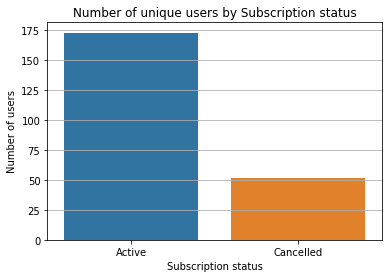

In [13]:
plt.grid(True)
df_ch_pd = df.drop_duplicates(['userId']).groupby(['user_churn']).count().sort("user_churn").toPandas()
sns.barplot(data =df_ch_pd, x = 'user_churn',y = 'count')
churn_d = ['Active', 'Cancelled']
x_pos = np.arange(len(churn_d))
plt.xticks(x_pos,churn_d)
plt.title('Number of unique users by Subscription status')
plt.ylabel('Number of users')
plt.xlabel('Subscription status')

In [ ]:
df_pandas = df.toPandas()

Text(0.5,0,'Subscription status')

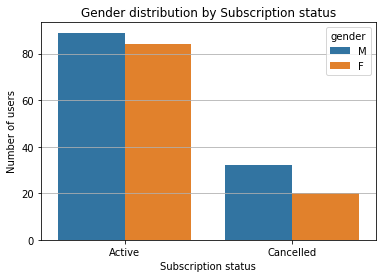

In [14]:
# Plotting a bar plot to show gender distribution by Subscription status
plt.grid(True)
df_ch_pd = df.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().sort("user_churn").toPandas()
sns.barplot(x = 'user_churn', y = 'count', data = df_ch_pd, hue = 'gender')
churn_d = ['Active', 'Cancelled']
y_pos = np.arange(len(churn_d))
plt.xticks(y_pos,churn_d)
plt.title("Gender distribution by Subscription status")
plt.ylabel('Number of users')
plt.xlabel('Subscription status')

Text(0.5,0,'Subscription status')

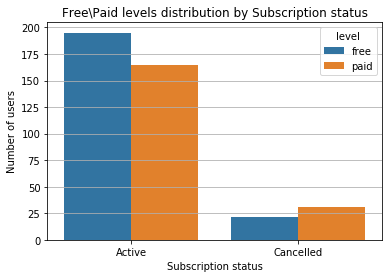

In [66]:
# Plotting a bar plot to show level distribution by Subscription status
plt.grid(True)
level_df = df.drop_duplicates(['userId','churn_value', 'level']).groupby(['churn_value', 'level']).count().sort("churn_value").toPandas()
sns.barplot(x = 'churn_value', y = 'count', data = level_df, hue = 'level')
churn_d = ['Active', 'Cancelled']
x_pos = np.arange(len(churn_d))
plt.xticks(x_pos,churn_d)
plt.title("Free\Paid levels distribution by Subscription status")
plt.ylabel('Number of users')
plt.xlabel('Subscription status')

Text(0.5,0,'% of envents')

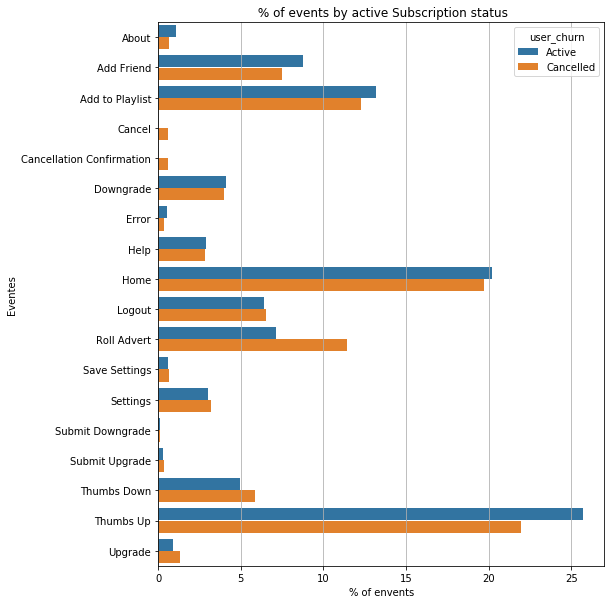

In [76]:
page_df = df.groupby(['page','user_churn']).count().toPandas()
page_df = page_df[page_df['page'] != 'NextSong']
page_df = ((page_df.groupby(['page','user_churn']).sum()/page_df.groupby(['user_churn']).sum())*100).reset_index()
page_df['user_churn'].replace({0:'Active', 1: 'Cancelled'},inplace = True)
plt.figure(figsize=(8,10))
plt.grid(True)
sns.barplot(y = 'page', x = 'count', data = page_df, hue = 'user_churn')
plt.title(" % of events by Subscription status")
sns.set_hls_values
plt.ylabel('Eventes')
plt.xlabel('% of envents')

In [69]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df = df.withColumn("hour", get_hour(df.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df = df.withColumn("weekday", get_weekday(df.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df = df.withColumn("day", get_day(df.ts))

Text(0.5,0,'Hour')

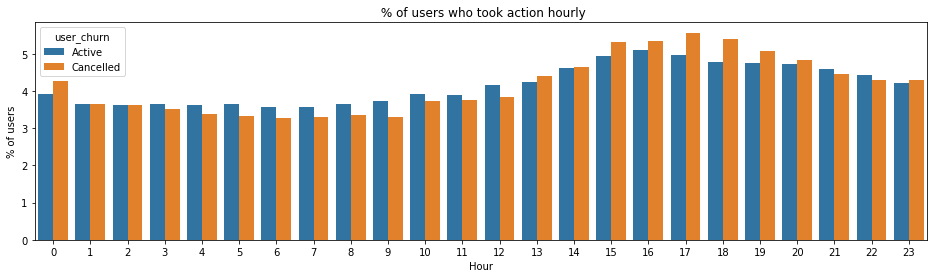

In [73]:
hour_df = df.groupby(['hour','user_churn']).count().toPandas()
hour_df1 = ((hour_df.groupby(['hour','user_churn']).sum()/hour_df.groupby(['user_churn']).sum())*100).reset_index()
hour_df1['hour'] = hour_df1['hour'].astype(int)
hour_df1['user_churn'].replace({0:'Active', 1: 'Cancelled'},inplace = True)
hour_df1.sort_values(by = 'hour', ascending=True,inplace = True)
plt.figure(figsize=(16,4))
sns.barplot(x = 'hour', y = 'count', data = hour_df1, hue = 'user_churn')
plt.title(" % of users who took action hourly")
sns.set_hls_values
plt.ylabel('% of users')
plt.xlabel('Hour')

Text(0.5,0,'Weekdays')

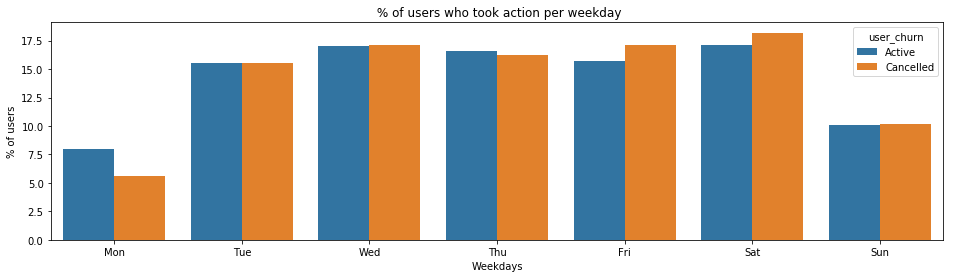

In [74]:
weekday_df = df.groupby(['weekday','user_churn']).count().toPandas()
weekday_df = ((weekday_df.groupby(['weekday','user_churn']).sum()/weekday_df.groupby(['user_churn']).sum())*100).reset_index()
weekday_df['weekday'] = weekday_df['weekday'].astype(int)
weekday_df['user_churn'].replace({0:'Active', 1: 'Cancelled'},inplace = True)
weekday_df.sort_values(by = 'weekday', ascending=True,inplace = True)
plt.figure(figsize=(16,4))
sns.barplot(x = 'weekday', y = 'count', data = weekday_df, hue = 'user_churn')
churn_d = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
x_pos = np.arange(len(churn_d))
plt.xticks(x_pos,churn_d)
plt.title(" % of users who took action per weekday")
plt.ylabel('% of users')
plt.xlabel('Weekdays')

Text(0.5,0,'day of month')

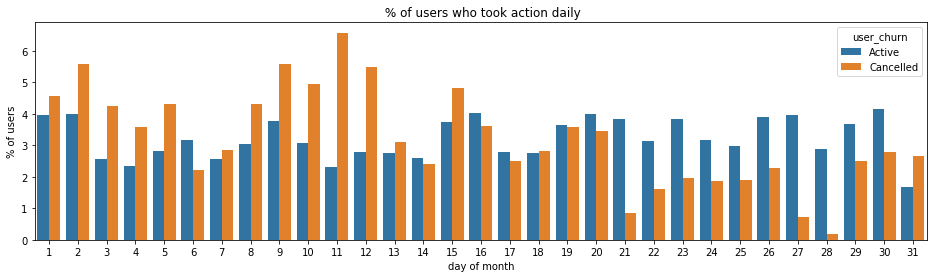

In [77]:
day_df = df.groupby(['day','user_churn']).count().toPandas()
day_df = ((day_df.groupby(['day','user_churn']).sum()/day_df.groupby(['user_churn']).sum())*100).reset_index()
day_df['day'] = day_df['day'].astype(int)
day_df['user_churn'].replace({0:'Active', 1: 'Cancelled'},inplace = True)
day_df.sort_values(by = 'day', ascending=True,inplace = True)
plt.figure(figsize=(16,4))
sns.barplot(x = 'day', y = 'count', data = day_df, hue = 'user_churn')
plt.title(" % of users who took action daily")
plt.ylabel('% of users')
plt.xlabel('day of month')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [10]:
# Feature 1 : Total number of  songs listened
feat_1 = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'tot_songs')


In [11]:
# Feature 2 : Total time spent 
feat_2 = df.select('userID','length').groupBy('userID').agg({'length':'sum'}).withColumnRenamed('sum(length)', 'listen_time')


In [12]:
# Feature 3 : Number of thumbs-up, Feature 4 : thumbs-down
feat_3 = df.select('userID','page').where(df.page == 'Thumbs Up').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'num_thumb_up')
feat_4 = df .select('userID','page').where(df.page == 'Thumbs Down').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'num_thumb_down')

In [13]:
# Feature 5 : Number of adds to playlist
feat_5 = df.select('userID','page').where(df.page == 'Add to Playlist').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'add_to_playlist')

In [14]:
# Feature 6 : Number of lifetime
feat_6 = df.select('userID','registration','ts').withColumn('lifetime',(df.ts-df.registration)).groupBy('userID').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lt')

In [15]:
# Feature 7 : Total number of friends
feat_7 = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'tot_friends')

In [16]:
# Feature 8 : Gender of the user
feat_8 = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))

In [17]:
# Feature 9: Number of help AND  Feature 10 : Number of rolladvert
feat_9 = df.select('userID','page').where(df.page == 'Help').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'help') 
feat_10 = df.select('userID','page').where(df.page == 'Roll Advert').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'rolladvert')

In [18]:
# Feature 11 : Total number of songs listened per session
feat_11  = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId')\
          .agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'avg_played_songs')

In [19]:
# Feature 12 : Total number of artists the user has listened to
feat_12 = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "tot_artist_played")


In [20]:
# setting the churn label for our model
target = df.select('userId', col('user_churn').alias('label')).dropDuplicates()

In [21]:
# Combining all features with the target churn label
final_data  = feat_1.join(feat_2,'userID','outer') \
    .join(feat_3,'userID','outer') \
    .join(feat_4,'userID','outer') \
    .join(feat_5,'userID','outer') \
    .join(feat_6,'userID','outer') \
    .join(feat_7,'userID','outer') \
    .join(feat_8,'userID','outer') \
    .join(feat_9,'userID','outer') \
    .join(feat_10,'userID','outer') \
    .join(feat_11,'userID','outer') \
    .join(feat_12,'userID','outer') \
    .join(target,'userID','outer') \
    .drop('userID') \
    .fillna(0)

In [22]:
final_data.show(5)

+---------+------------------+------------+--------------+---------------+-----------+-----------+------+----+----------+------------------+-----------------+-----+
|tot_songs|       listen_time|num_thumb_up|num_thumb_down|add_to_playlist|         lt|tot_friends|gender|help|rolladvert|  avg_played_songs|tot_artist_played|label|
+---------+------------------+------------+--------------+---------------+-----------+-----------+------+----+----------+------------------+-----------------+-----+
|      381| 66940.89735000003|          17|             5|              7| 4807612000|          4|     0|   2|        52|39.285714285714285|              252|    0|
|      474| 94008.87593999993|          21|             6|              8| 6054448000|          4|     1|   2|         7|              64.5|              339|    0|
|       11|2089.1131000000005|           0|             0|              0| 6161779000|          0|     1|   0|         1|               8.0|                8|    1|
|     4825

In [23]:
incol = ['tot_songs',
 'listen_time',
 'num_thumb_up',
 'num_thumb_down',
 'add_to_playlist',
 'lt',
 'tot_friends',
 'gender',
 'help',
 'rolladvert',
 'avg_played_songs',
 'tot_artist_played']
assembler = VectorAssembler(inputCols=incol, outputCol="NumFeatures")
final_data = assembler.transform(final_data)

In [24]:
scaler2 = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler2.fit(final_data)
final_data = scalerModel.transform(final_data)

In [37]:
final_data.take(2)

[Row(tot_songs=381, listen_time=66940.89735000003, num_thumb_up=17, num_thumb_down=5, add_to_playlist=7, lt=4807612000, tot_friends=4, gender=0, help=2, rolladvert=52, avg_played_songs=39.285714285714285, tot_artist_played=252, label=0, NumFeatures=DenseVector([381.0, 66940.8974, 17.0, 5.0, 7.0, 4807612000.0, 4.0, 0.0, 2.0, 52.0, 39.2857, 252.0]), features=DenseVector([0.2866, 0.2431, 0.2596, 0.3823, 0.214, 1.4775, 0.1943, 0.0, 0.2761, 2.413, 0.9219, 0.4173])),
 Row(tot_songs=474, listen_time=94008.87593999993, num_thumb_up=21, num_thumb_down=6, add_to_playlist=8, lt=6054448000, tot_friends=4, gender=1, help=2, rolladvert=7, avg_played_songs=64.5, tot_artist_played=339, label=0, NumFeatures=DenseVector([474.0, 94008.8759, 21.0, 6.0, 8.0, 6054448000.0, 4.0, 1.0, 2.0, 7.0, 64.5, 339.0]), features=DenseVector([0.3565, 0.3414, 0.3207, 0.4588, 0.2445, 1.8606, 0.1943, 2.0013, 0.2761, 0.3248, 1.5135, 0.5613]))]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [25]:
final_data2 = final_data.select('label','features')

In [36]:
final_data2.take(1)

[Row(label=0, features=DenseVector([0.2866, 0.2431, 0.2596, 0.3823, 0.214, 1.4775, 0.1943, 0.0, 0.2761, 2.413, 0.9219, 0.4173]))]

In [26]:
test,validation = final_data2.randomSplit([0.8, 0.2], seed=50)

In [27]:
# Models to train: logistic regression, svm, gradient boosting tree
logistic_reg = LogisticRegression(maxIter=10, regParam =0.0)
gbt = GBTClassifier(maxDepth = 5, maxIter = 10, seed = 42)
svm = LinearSVC (maxIter = 10,  regParam = 0.01)

In [28]:
#Logistic Regression
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(logistic_reg.regParam,[0.0, 0.05, 0.1]) \
    .build()
crossval = CrossValidator(estimator=logistic_reg,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q1 = crossval.fit(test)
cvModel_q1.avgMetrics

[0.7457035409954094, 0.6896357938282245, 0.6931605083686441]

In [29]:
# Support Vector Machine 
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam,[0.01, 0.05, 0.5]) \
    .build()
crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q2 = crossval.fit(test)
cvModel_q2.avgMetrics

[0.6693459731200732, 0.6693459731200732, 0.6693459731200732]

In [30]:
# Gradient boosted tree
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .build()
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q3 = crossval.fit(test)
cvModel_q3.avgMetrics

[0.7104618008281558, 0.6910921737095559]

In [31]:
gbt_tuned = GBTClassifier(maxDepth=5,maxIter=10,seed=42)
gbt_model = gbt_tuned.fit(test)
results = gbt_model.transform(validation)

In [32]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))

0.7567567567567568


In [33]:
print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

0.76094659252554


In [34]:
gbt_model.featureImportances

SparseVector(12, {0: 0.1505, 1: 0.0873, 2: 0.0475, 3: 0.1432, 4: 0.051, 5: 0.1959, 6: 0.1047, 7: 0.0103, 8: 0.0316, 9: 0.1139, 10: 0.0637, 11: 0.0003})

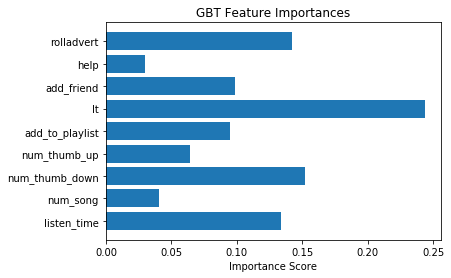

In [35]:
importances  = [ 0.134,0.0408,0.1519,0.0639,0.0946,0.2436,0.0988,0.0301,0.1421]
feature = ["listen_time", "num_song", "num_thumb_down", \
          'num_thumb_up','add_to_playlist','lt','add_friend','help','rolladvert']
y_pos = np.arange(len(feature))
 
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, feature)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances')
plt.savefig('GBT feature Importance.png', dpi=300)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.